In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer, AutoConfig

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
os.environ["WANDB_DISABLED"] = "true"
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cpc-codes/titles.csv
/kaggle/input/deberta-v3-large/spm.model
/kaggle/input/deberta-v3-large/config.json
/kaggle/input/deberta-v3-large/README.md
/kaggle/input/deberta-v3-large/tf_model.h5
/kaggle/input/deberta-v3-large/tokenizer_config.json
/kaggle/input/deberta-v3-large/pytorch_model.bin
/kaggle/input/new-tensorflow-deberta-v3-large-model-uspppm/new2_deberta_v3large_patent_1.h5
/kaggle/input/new-tensorflow-deberta-v3-large-model-uspppm/__results__.html
/kaggle/input/new-tensorflow-deberta-v3-large-model-uspppm/new2_deberta_v3large_patent_4.h5
/kaggle/input/new-tensorflow-deberta-v3-large-model-uspppm/new2_deberta_v3large_patent_2.h5
/kaggle/input/new-tensorflow-deberta-v3-large-model-uspppm/new2_deberta_v3large_patent_3.h5
/kaggle/input/new-tensorflow-deberta-v3-large-model-uspppm/new2_deberta_v3large_patent_0.h5
/kaggle/input/new-tensorflow-deberta-v3-large-model-uspppm/submission.csv
/kaggle/input/new-tensorflow-deberta-v3-large-model-uspppm/__notebook__.ipynb
/kaggle

# Defining all the parameters of the NLP model

In [2]:
model_name = "../input/deberta-v3-large"
max_len = 32 # Maxmimum Length of the sentence that will be input to the model
NUM_EPOCHS = 4
batch_size=8
LR = 1e-5 # This the learning rate
fold = 5 # Stratified K-fold number

`test` variable will be holding the test dataset.

In [3]:
test = pd.read_csv("../input/us-patent-phrase-to-phrase-matching/test.csv")
test.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


`title` dataset holds the actual training dataset

In [4]:
title = pd.read_csv("../input/cpc-codes/titles.csv")
title.head()

,code,title,section,class,subclass,group,main_group
0,A,HUMAN NECESSITIES,A,NaN,NaN,NaN,NaN
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTI...,A,1.0,NaN,NaN,NaN
2,A01B,SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS...,A,1.0,B,NaN,NaN
3,A01B1/00,Hand tools (edge trimmers for lawns A01G3/06 ...,A,1.0,B,1.0,0.0
4,A01B1/02,Spades; Shovels {(hand-operated dredgers E02F3...,A,1.0,B,1.0,2.0


Modifying the `test` dataset: adding a column of the *title*, which hold the details of the *context* column.

In [5]:
test = pd.merge(test, title[["code","title"]], 
                 left_on = "context", right_on = "code",
                 how='left')
test.head()

,id,anchor,target,context,code,title
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,G02,OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,F23,COMBUSTION APPARATUS; COMBUSTION PROCESSES
2,36baf228038e314b,lower trunnion,lower locating,B60,B60,VEHICLES IN GENERAL
3,1f37ead645e7f0c8,cap component,upper portion,D06,D06,TREATMENT OF TEXTILES OR THE LIKE; LAUNDERING;...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,H04,ELECTRIC COMMUNICATION TECHNIQUE


Dropping the *context* column from the `test` dataset because the *code* already withold the same information

In [6]:
test = test.drop(["context"],axis=1)
test.head()

,id,anchor,target,code,title
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,COMBUSTION APPARATUS; COMBUSTION PROCESSES
2,36baf228038e314b,lower trunnion,lower locating,B60,VEHICLES IN GENERAL
3,1f37ead645e7f0c8,cap component,upper portion,D06,TREATMENT OF TEXTILES OR THE LIKE; LAUNDERING;...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRIC COMMUNICATION TECHNIQUE


In [7]:
test['anchor'] = test['anchor'].str.lower() # Lowering the letters as data preprocessing steps
test['target'] = test['target'].str.lower() # Lowering the letters as data preprocessing steps
test.head()

,id,anchor,target,code,title
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,COMBUSTION APPARATUS; COMBUSTION PROCESSES
2,36baf228038e314b,lower trunnion,lower locating,B60,VEHICLES IN GENERAL
3,1f37ead645e7f0c8,cap component,upper portion,D06,TREATMENT OF TEXTILES OR THE LIKE; LAUNDERING;...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRIC COMMUNICATION TECHNIQUE


In [8]:
test['anchor'] = test['anchor'].str.replace('[^\w\s]','',regex=True) # Removing punctuation as data preprocessing steps
test['target'] = test['target'].str.replace('[^\w\s]','',regex=True) # Removing punctuation as data preprocessing steps
test.head()

,id,anchor,target,code,title
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,COMBUSTION APPARATUS; COMBUSTION PROCESSES
2,36baf228038e314b,lower trunnion,lower locating,B60,VEHICLES IN GENERAL
3,1f37ead645e7f0c8,cap component,upper portion,D06,TREATMENT OF TEXTILES OR THE LIKE; LAUNDERING;...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRIC COMMUNICATION TECHNIQUE


In [9]:
import re
test["title"] = test["title"].apply(lambda x:re.sub('[;,]', '', x)) # Removing specified characters as data preprocessing steps

In [10]:
test.head()

,id,anchor,target,code,title
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,COMBUSTION APPARATUS COMBUSTION PROCESSES
2,36baf228038e314b,lower trunnion,lower locating,B60,VEHICLES IN GENERAL
3,1f37ead645e7f0c8,cap component,upper portion,D06,TREATMENT OF TEXTILES OR THE LIKE LAUNDERING F...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRIC COMMUNICATION TECHNIQUE


# Creating the Tokenizer

In [11]:
# Intializing the deberta tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


PreTrainedTokenizer(name_or_path='../input/deberta-v3-large', vocab_size=128000, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

The `create_data` function creates the input data for the Deberta V3 Large model. If the `train_status` is *True* then the corresponding score value (`label`) is returned, which is primarily used during the training period of the model.

In [12]:
def create_data(id_, anchor, target, code, title, score, tokenizer, max_len, train_status=True):
    input_ids = []
    attention_mask = []
    token_type_ids = []
    labels = []
    ids = []
    encoded_sent = tokenizer.batch_encode_plus([(k[0] + " " + k[2], k[1]) for k in zip(anchor,target,title)],\
                                                max_length = max_len,\
                                                padding = "max_length", truncation = True)
    for i in range(len(anchor)): 
        ids.append(id_[i])
        input_ids.append(encoded_sent['input_ids'][i])
        attention_mask.append(encoded_sent['attention_mask'][i])
        if train_status:
            labels.append(score[i])
    return {"input_ids":input_ids,
            "attention_mask":attention_mask,
            "ids":ids, 
            }, labels

# Creating the test data, which will be used to input into the NLP model.

In [13]:
test_data, test_labels = create_data(test['id'].tolist(),\
                                   test['anchor'].tolist(),\
                                   test['target'].tolist(),\
                                   test['code'].tolist(),\
                                   test['title'].tolist(),\
                                   None, tokenizer, max_len,\
                                   train_status=False)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


# Creating the NLP model

In [14]:
def build_model(model_name, MAX_LEN):
    
    input__ids = tf.keras.Input(shape=(MAX_LEN, ), dtype = tf.int32)
    input__mask = tf.keras.Input(shape=(MAX_LEN, ), dtype = tf.int32)
    config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
    transformer = TFAutoModel.from_pretrained(model_name, trainable=True)
    x = transformer(input_ids = input__ids, 
                      attention_mask = input__mask)
    #print(x.last_hidden_state)
    #x = tf.keras.layers.GlobalAveragePooling1D()(x.last_hidden_state)
    x = tf.keras.layers.Dropout(config.hidden_dropout_prob)(x.last_hidden_state)
    x=tf.keras.layers.Dense(2*config.hidden_size,\
                            kernel_initializer= \
                            tf.keras.initializers.RandomNormal(mean=0.0,\
                                                               stddev=config.initializer_range),
                            activation='relu')(x)
    x = tf.keras.layers.Dropout(2*config.hidden_dropout_prob)(x)
    x=tf.keras.layers.Dense(2*config.hidden_size,\
                            kernel_initializer= \
                            tf.keras.initializers.RandomNormal(mean=0.0,\
                                                               stddev=config.initializer_range))(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    fnl = tf.keras.layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs = [input__ids, input__mask], 
                           outputs = fnl)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LR), loss = "mse")
    return model

# Creating the callback Pearson Correlation coefficient as a tracking metrics for the model

In [15]:
from scipy.stats import pearsonr

class PearsonCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
    #    pass
        #print(dir(self.model))
        self.X_val, self.Y_val = val_data
    #def on_epoch_start(self,epoch):
    #    print(f"Learning rate: {self.model.optimize.learning_rate}")
    def on_epoch_end(self, epoch, logs):
        X_val_preds = self.model.predict(self.X_val)
        #print(X_val_preds.shape,self.Y_val.shape)
        pearson_corr = pearsonr(X_val_preds.ravel(), self.Y_val)
        print("pearsonr_val (from log) =", pearson_corr[0])
        logs["val_pearsonr"] = pearson_corr[0]

`scheduler` is the rate at which the learning rate will change in each epoch.

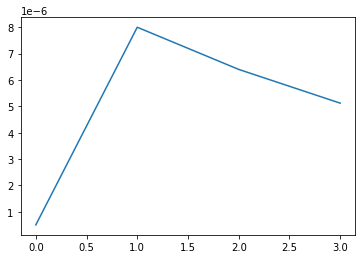

In [16]:
import matplotlib.pyplot as plt

def scheduler(epoch):
    learning_rate = LR
    if epoch == 0:
        return learning_rate * 0.05
    else:
        return learning_rate * (0.8**epoch)
    
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

plt.plot([scheduler(e) for e in range(NUM_EPOCHS)])

# Intializing the Deberta V3 Large Model

In [17]:
model = build_model(model_name, max_len)

2022-05-05 10:01:13.274421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 10:01:13.276293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 10:01:13.278978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 10:01:13.292057: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Generating the score value for the test set
In the notebook, **new-tensorflow-deberta-v3-large-model-uspppm** we have trained and saved different models on different dataset folds. Now we predict the score value for the test dataset from each of the training folds, and finally write down the mean for each sample of the test set.   

In [18]:
predictions = []
for fld in range(1,fold):
    model.load_weights(f"../input/new-tensorflow-deberta-v3-large-model-uspppm/new2_deberta_v3large_patent_{fld}.h5")
    test_preds = model.predict((np.asarray(test_data['input_ids']),
                                np.asarray(test_data['attention_mask']),
                               #np.asarray(test_data['token_type_ids']),
                               ))
    prediction = test_preds.reshape(-1)
    predictions.append(prediction)
predictions = np.mean(predictions, axis=0)
predictions

2022-05-05 10:02:09.174930: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


array([ 0.49260563,  0.6887337 ,  0.51726794,  0.19416131, -0.04635803,
        0.44849274,  0.4479335 , -0.05245592,  0.28675613,  1.1416916 ,
        0.17254221,  0.24643686,  0.7722764 ,  0.93151134,  0.7539686 ,
        0.27093008,  0.25349414, -0.04630439,  0.49479356,  0.2703356 ,
        0.41052246,  0.23741607, -0.01034431,  0.21066287,  0.5374259 ,
       -0.04611911, -0.02894833, -0.04408982, -0.04906857,  0.600369  ,
        0.1300444 , -0.01999174,  0.66389924,  0.5410953 ,  0.26922172,
        0.18724379], dtype=float32)

# Generating the Submission File

In [19]:
# initialize data of lists.
submission = {'id':test['id'],\
              'score':predictions}
 
# Create DataFrame
submission = pd.DataFrame(submission)

In [20]:
submission['score'] = submission.score.apply(lambda x: 0 if x < 0 else x)
submission['score'] = submission.score.apply(lambda x: 1 if x > 1 else x)
submission.to_csv('submission.csv', index=False)

In [21]:
submission

,id,score
0,4112d61851461f60,0.492606
1,09e418c93a776564,0.688734
2,36baf228038e314b,0.517268
3,1f37ead645e7f0c8,0.194161
4,71a5b6ad068d531f,0.000000
5,474c874d0c07bd21,0.448493
6,442c114ed5c4e3c9,0.447933
7,b8ae62ea5e1d8bdb,0.000000
8,faaddaf8fcba8a3f,0.286756
9,ae0262c02566d2ce,1.000000


# I obtain the Submission Score for the above logic = 0.84